# Quantum computing and its applications (BMEVIHIAD00)
## Programming quantum computers 4. - Simple quantum algorithms
Botond László Márton (martonbotondlaszlo@edu.bme.hu)

2025.04.02.

## Content

Once again we will be solving problems with the `qiskit`. The calculations can be done on paper, but if anyone has a computer, feel free to follow the steps.

## Teleportation

Let's implement the teleportation protocol in `qiskit`. As a reminder the circuit corresponding to it is:

<center><img src="teleport_circ.png" style="width: 50%"></center>

If we would like to control a quantum gate with a classical bit (a measurement result), we can do this in `qiskit` as:

```python
qc.x(index_of_qubit).c_if(index_of_classical_bit, value_for_which_it_should_be_used)
```

The teleportation protocol in `qiskit`:

In [2]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.quantum_info import random_statevector
from qiskit_aer import Aer

crx = ClassicalRegister(1, 'crx')
crz = ClassicalRegister(1, 'crz')

backend = Aer.get_backend("aer_simulator")

qbits = QuantumRegister(3, 'q')
qc = QuantumCircuit(qbits, crz, crx)

svector = random_statevector(2)
qc.initialize(svector, 0)

qc.h(1)
qc.cx(1,2)
qc.cx(0,1)
qc.h(0)
qc.save_statevector(label="Before measurement")
qc.measure(0, crz)
qc.measure(1, crx)
qc.save_statevector(label="After measurement")

qc.x(2).c_if(crx, 1) 
qc.z(2).c_if(crz, 1)

/tmp/ipykernel_3636/3679911133.py:25: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(2).c_if(crx, 1)
/tmp/ipykernel_3636/3679911133.py:26: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(2).c_if(crz, 1)


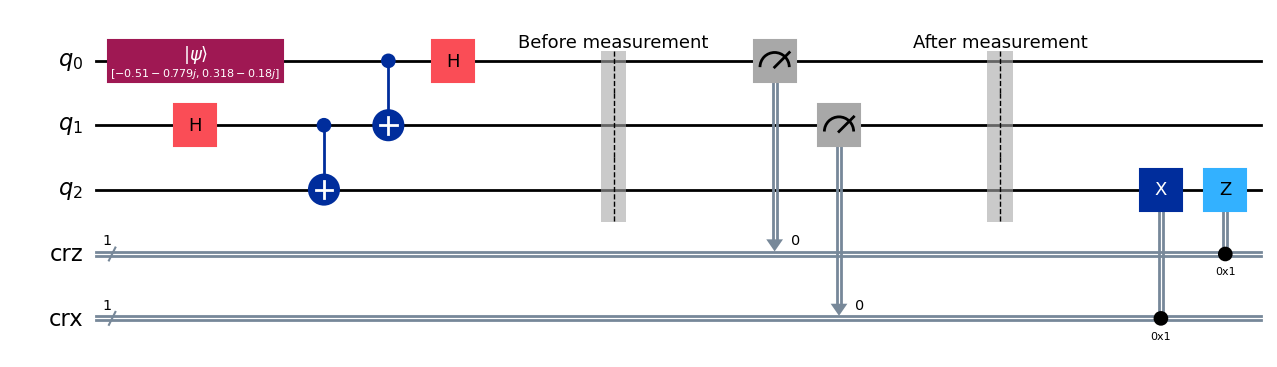

In [3]:
qc.draw("mpl")

In [4]:
def get_statevector_from_result(result, label: str):
    result_dict = result.to_dict()
    data = result_dict["results"][0]["data"]
    if label in data.keys():
        return data[label]
    return None

In [5]:
sim = Aer.get_backend("statevector_simulator")
result = sim.run(qc).result()

In [6]:
print(get_statevector_from_result(result, "Before measurement"))
print(get_statevector_from_result(result, "After measurement"))
print(get_statevector_from_result(result, "statevector"))

Statevector([-0.25478892-0.38953266j, -0.25478892-0.38953266j,
              0.15899575-0.08981796j, -0.15899575+0.08981796j,
              0.15899575-0.08981796j, -0.15899575+0.08981796j,
             -0.25478892-0.38953266j, -0.25478892-0.38953266j],
            dims=(2, 2, 2))
Statevector([ 0.        +0.j        ,  0.        -0.j        ,
              0.        +0.j        , -0.3179915 +0.17963591j,
              0.        +0.j        , -0.        +0.j        ,
              0.        +0.j        , -0.50957785-0.77906531j],
            dims=(2, 2, 2))
Statevector([ 0.        +0.j        , -0.        +0.j        ,
              0.        +0.j        , -0.50957785-0.77906531j,
             -0.        +0.j        ,  0.        +0.j        ,
             -0.        +0.j        ,  0.3179915 -0.17963591j],
            dims=(2, 2, 2))


Or in an other way:

In [7]:
crx = ClassicalRegister(1, 'crx')
crz = ClassicalRegister(1, 'crz')

backend = Aer.get_backend("aer_simulator")

qbits = QuantumRegister(3, 'q')
qc = QuantumCircuit(qbits, crz, crx)

svector = random_statevector(2)
qc.initialize(svector, 0)

qc.h(1)
qc.cx(1,2)
qc.barrier(label="Charlie")

qc.cx(0,1)
qc.h(0)
qc.measure(0, crz)
qc.measure(1, crx)
qc.barrier(label="Alice")

with qc.if_test((crx, 1)):
    qc.x(2)


with qc.if_test((crz, 1)):
    qc.z(2)

qc.save_statevector()

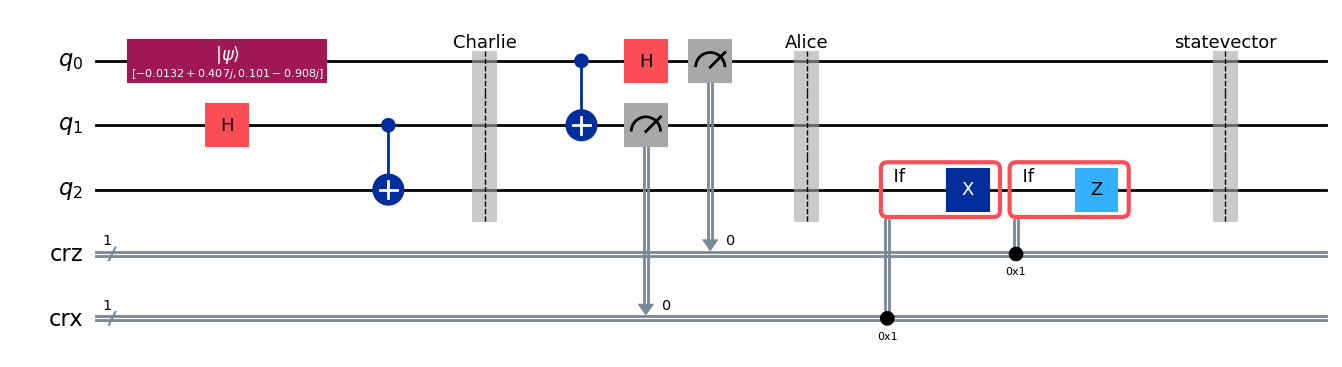

In [8]:
qc.draw("mpl")

Classical control structures:

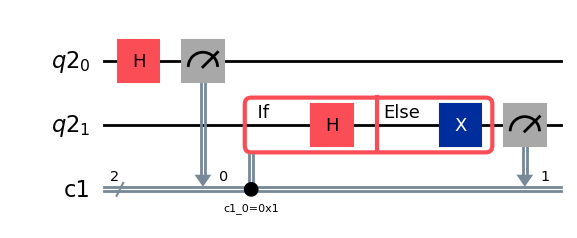

In [10]:
# Of course, qiskit has the if-else as well
qubits = QuantumRegister(2)
clbits = ClassicalRegister(2)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1) = qubits
(c0, c1) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)) as else_:
    circuit.h(q1)
with else_:
    circuit.x(q1)
circuit.measure(q1, c1)
 
circuit.draw("mpl")

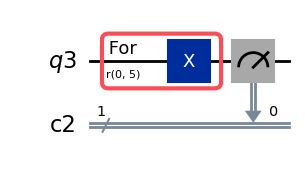

In [11]:
# We can also use a for and a while loop:
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
with circuit.for_loop(range(5)) as _:
    circuit.x(q0)
circuit.measure(q0, c0)
 
circuit.draw("mpl")

## Measurement in a given basis

During projective measurement, we've learned that we can make a measurement in any orthogonal basis.

For example: We can make projections corresponding to the $|0\rangle$, $|1\rangle$ states: $P_0 = |0\rangle\langle0|$, $P_1 = |1\rangle\langle1|$, which statisfy the completeness relation $P_0 + P_1 = I$

### $|0\rangle$ in another basis

What are the measurement probabilites when perform a projective measurement of $|0\rangle$ in the $|+\rangle,|-\rangle$ basis?

Hint: We can of course calculate the necessary projections and get the probabilites using the Born-rule, but try to find a different method.

**Solution**:

As we know, $|+\rangle = H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ and $|-\rangle = H|1\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$.

From this we can conculude that $|0\rangle = \frac{1}{\sqrt{2}}|+\rangle + \frac{1}{\sqrt{2}}|-\rangle$

Then the probabilities are:
* $|\braket{+|0}|^2 = 1/2$ for measuring $|+\rangle$ 
* $|\braket{-|0}|^2 = 1/2$ for measuring $|-\rangle$ 

### Measurement in a different basis

What are the measurement probabilites for $0.6|0\rangle + 0.8|1\rangle$ in the $|i\rangle, |-i\rangle$ basis?

Where $|i\rangle = \frac{1}{\sqrt{2}}(|0\rangle + i|1\rangle)$ and $|-i\rangle = \frac{1}{\sqrt{2}}(|0\rangle - i|1\rangle)$.

Hint: Now use the steps learned for the projective measurements!

**Solution:**

Let's calculate the two projections $P_{i}$ -t és $P_{-i}$ -t :
    $$P_{i} = \ket{i}\bra{i} = \frac{1}{2} \begin{bmatrix} 1 \\ i \end{bmatrix} \begin{bmatrix} 1 & -i \end{bmatrix} = \frac{1}{2} \begin{bmatrix}1 & -i \\ i & 1 \end{bmatrix},$$
    $$P_{-i} = \ket{-i}\bra{-i} = \frac{1}{2} \begin{bmatrix} 1 \\ -i \end{bmatrix} \begin{bmatrix} 1 & i \end{bmatrix} = \frac{1}{2} \begin{bmatrix}1 & i \\ -i & 1 \end{bmatrix}.$$

After this the probabilites are:
    $$\begin{align}P(i |\psi\rangle) = \langle\psi | P_{+i} \ket \psi &= \begin{bmatrix} 0.6 & 0.8 \end{bmatrix} \times \frac{1}{2} \begin{bmatrix}1 & -i \\ i & 1\end{bmatrix} \times \begin{bmatrix} 0.6 \\ 0.8 \end{bmatrix}\\ &= \begin{bmatrix} 0.6 & 0.8 \end{bmatrix} \times \frac{1}{2} \begin{bmatrix} 0.6 - 0.8i \\ 0.8 + 0.6i \end{bmatrix} = \frac{1}{2}\end{align}$$
    $$\begin{align}P(i |\psi\rangle) = \langle\psi | P_{-i} \ket \psi &= \begin{bmatrix} 0.6 & 0.8 \end{bmatrix} \times \frac{1}{2} \begin{bmatrix}1 & i \\ -i & 1\end{bmatrix} \times \begin{bmatrix} 0.6 \\ 0.8 \end{bmatrix}\\ &= \begin{bmatrix} 0.6 & 0.8 \end{bmatrix} \times \frac{1}{2} \begin{bmatrix} 0.6 + 0.8i \\ 0.8 - 0.6i \end{bmatrix} = \frac{1}{2}\end{align}$$

What happens if we can only measure in the $|0\rangle, |1\rangle$ basis, but the state is currently represented in another?

Formally, we have a state $|\psi\rangle = c_0|b_0\rangle + c_1|b_1\rangle$, where $|b_0\rangle$ and $|b_1\rangle$ orthogonal and $|c_0|^2 + |c_1|^2 = 1$. But we can only measure in the ${|b_0\rangle, |b_1\rangle}$ basis. How can we still get the same measurement probabilities and corresponding states (as per the measurement postulate)?

We will create a transformation $U$, which takes $|\psi\rangle$ from one basis to the other (that is from $\ket{b_0}, \ket{b_1}$ to ${\ket{0}, \ket{1}}$). Then we measure it there and transform it back. How does the matrix of $U$ look like?

We know that is should behave in the following way:

$$
\begin{align}
U|b_0\rangle &= |0\rangle \\
U|b_1\rangle &= |1\rangle \\
U^{\dagger}|0\rangle &= |b_0\rangle \\
U^{\dagger}|1\rangle &= |b_1\rangle
\end{align}
$$

Putting it together: 
$$U = |0\rangle\langle b_0| + |1\rangle\langle b_1|$$
$$U^{\dagger} = |b_0\rangle\langle 0| + |b_1\rangle\langle 1|$$


Why does this work?

Example:

$$U|b_0\rangle = |0\rangle\langle b_0|b_0\rangle + |1\rangle\langle b_1|b_0\rangle = |0\rangle \times 1 + |1\rangle \times 0 = |0\rangle$$

$$U^{\dagger}|0\rangle = |b_0\rangle\langle 0|0\rangle + |b_1\rangle\langle 1|0\rangle = |b_0\rangle \times 1 + |b_1\rangle \times 0 = |b_0\rangle$$

General case:

$$
\begin{align}
U(c_0|b_0\rangle + c_1|b_1\rangle) &= |0\rangle\langle b_0|(c_0|b_0\rangle + c_1|b_1\rangle) + |1\rangle\langle b_1|(c_0|b_0\rangle + c_1|b_1\rangle) \\
&= c_0|0\rangle\langle b_0|b_0\rangle + c_1|0\rangle\langle b_0|b_1\rangle + c_0|1\rangle\langle b_1|b_0\rangle + c_1|1\rangle\langle b_1|b_1\rangle \\
&= c_0|0\rangle \times 1 + c_1|0\rangle \times 0 + c_0|1\rangle \times 0 + c_1|1\rangle \times 1 \\
&= c_0|0\rangle + c_1|1\rangle
\end{align}
$$

You can also check that $U$ is unitary.

In summary:

1. With the help of $U$ we transform our state from a given basis to the ${\ket{0}, \ket{1}}$ basis.
2. We perform the measurements there, for which the probabilities do not change.
3. Using $U^{\dagger}$ we transform the state back to the original basis and the state will correspond to a measurement in the original basis.

With these steps we can perform a projective measurement in any basis without calculating the necessary projections!

### Distinguishing orthogonal states

We found a black box with the following note: This box outputs $\ket{i}$ or $\ket{-i}$ with equal probability.

Create an algorithm that is able to distinguish the outputs of this box with $100 \%$ accuracy.

Reminder:

$$U = |0\rangle\langle b_0| + |1\rangle\langle b_1|$$
$$U^{\dagger} = |b_0\rangle\langle 0| + |b_1\rangle\langle 1|$$

**Solution:**

Because $\ket{i}$ and $\ket{-i}$ are orthogonal, we can use the subsitution $\ket{b_0} = \ket{i}$ and $\ket{b_1} = \ket{-i}$ to write up $U$ as follows:

$$
\begin{align}
U &= |0\rangle\langle i| + |1\rangle\langle -i| =\begin{bmatrix} 1 \\ 0 \end{bmatrix} \times \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & i \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} \times \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & -i \end{bmatrix}\\
&= \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & -i \\ 0 & 0 \end{bmatrix} + \frac{1}{\sqrt{2}} \begin{bmatrix} 0 & 0 \\ 1 & i \end{bmatrix} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & -i \\ 1 & i \end{bmatrix}
\end{align}
$$

In [12]:
from qiskit.circuit.library import UnitaryGate
import numpy as np
import random

qc = QuantumCircuit(1, 1)

ket_i = np.array([1, 1j]) * 1/np.sqrt(2)
ket_minus_i = np.array([1, -1j]) * 1/np.sqrt(2)

u_gate_matrix = np.array([[1, -1j], [1, 1j]]) * 1/np.sqrt(2)
u_gate = UnitaryGate(u_gate_matrix)

if random.randint(0,1):
    qc.initialize(ket_i)
else:
    qc.initialize(ket_minus_i)

qc.append(u_gate, [0])
qc.measure(0, 0)

Let's check it:

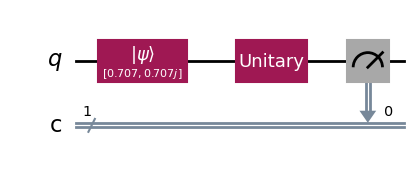

In [13]:
qc.draw("mpl")

In [17]:
backend = AerSimulator()
result = backend.run(qc, shots=1000).result()
counts = result.get_counts()
print(counts)

{'0': 1000}


#### Performing the complete measurement

Let's add one more step to the previous exercise: After the measurement we would like to have the state $\ket{i}$ or $\ket{-i}$, based on the result.

**Solution**:

We only have to calculate the adjoint of $U$:

$$
U^{\dagger} = (U^{\ast})^{T} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ i & -i \end{bmatrix}
$$

Let's extend the circuit:

In [14]:
qc = QuantumCircuit(1,1)

ket_i = np.array([1, 1j]) * 1/np.sqrt(2)
ket_minus_i = np.array([1, -1j]) * 1/np.sqrt(2)

u_gate_matrix = np.array([[1, -1j], [1, 1j]]) * 1/np.sqrt(2)
u_gate = UnitaryGate(u_gate_matrix)

if random.randint(0,1):
    qc.initialize(ket_i)
else:
    qc.initialize(ket_minus_i)

qc.append(u_gate, [0])
qc.measure(0, 0)
qc.append(u_gate.adjoint(), [0])

Check the circuit:

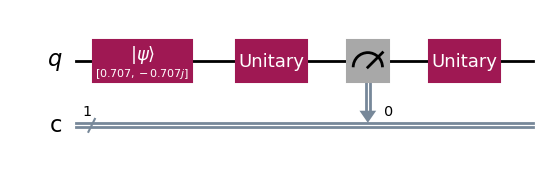

In [15]:
qc.draw("mpl")

In [16]:
sim = Aer.get_backend("statevector_simulator")
result = sim.run(qc).result().get_statevector()
print(result)

Statevector([0.70710678+0.j        , 0.        -0.70710678j],
            dims=(2,))


### Dinstinguishing orthogonal states - Solution 2.

Transform the state $\ket{0}$ to $\ket{i}$ using the gates from the previous lectures!

Reminder: $\ket{i} = \frac{1}{\sqrt{2}}(\ket{0} + i\ket{1})$

The matrix of the $S$ gate is:

$$
S = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix}
$$

The matrix of the $T$ gate is:

$$
T = \begin{bmatrix}
1 & 0 \\
0 & e^{i\pi/4}
\end{bmatrix}
$$

**Solution**:

First apply the $H$ gate to get $\ket{+} = \frac{1}{\sqrt{2}}(\ket{0} + \ket{1})$, then use the $S$ gate to get the desired state $\ket{i} = \frac{1}{\sqrt{2}}(\ket{0} + i\ket{1})$.

The matrix of the $S$ gate is:

$$
S = \begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix}
$$

The whole transformation is: $$SH\ket{0} = \ket{i}$$

We can also check that the adjoint of $SH$ takes $\ket{1}$ -to $\ket{-i}$.

Furthermore $SH$ is unitary as both $S$ and $H$ are unitary, so it can be reversed and the matrix of the adjoint is:

$$
 (SH)^{\dagger} = H^{\dagger} S^{\dagger} = H S^{\dagger} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \times \begin{bmatrix} 1 & 0 \\ 0 & -i \end{bmatrix} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & -i \\ 1 & i \end{bmatrix}
$$

But this is the same matrix we got for $U$ (and also  $U^{\dagger} = SH$).

We can simplify the circuit:

In [17]:
qc = QuantumCircuit(1,1)

ket_i = np.array([1, 1j]) * 1/np.sqrt(2)
ket_minus_i = np.array([1, -1j]) * 1/np.sqrt(2)

if random.randint(0,1):
    qc.initialize(ket_i)
else:
    qc.initialize(ket_minus_i)

qc.sdg(0)
qc.h(0)
qc.measure(0, 0)

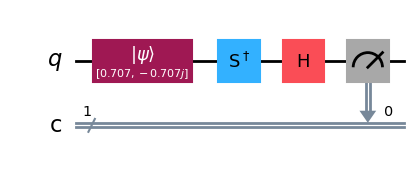

In [18]:
qc.draw("mpl")

In [19]:
sim = Aer.get_backend("aer_simulator")
result = sim.run(qc, shots=1000).result().get_counts()
print(result)

{'1': 1000}


## Parametrization of circuits in `qiskit`

![Forgatási kapuk](rotation_gates.png)

Often, we want to use the same circuit (or algorithm) more than once, but in a slightly different way. For example, the rotation angle used for the $R_y$ gate above changes in different execution of a circuit.

We can solve this problem with `qiskit`'s `Parameter` class.

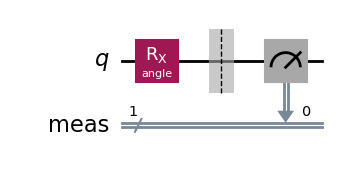

In [20]:
from qiskit.circuit import Parameter

angle = Parameter("angle")  # We do not specify a value upon declaration.

qc = QuantumCircuit(1)
qc.rx(angle, 0)
qc.measure_all()
qc.draw("mpl")

A `Parameter` must a value specified during the execution of the circuit. For this we use the `assign_parameters` function.

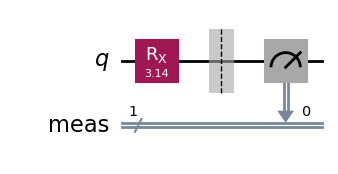

In [21]:
bc = qc.assign_parameters({angle: 3.14})
bc.draw('mpl')

## Running multiple circuits at the same time

If there are numerous circuits that we would like to simulate together, we can do the following:

In [22]:
circuits = []
circuit_names = []
for value in range(10):
    circuits.append(qc.assign_parameters({ angle: value }))
    circuit_names.append(f"Circuit with angle={value}")

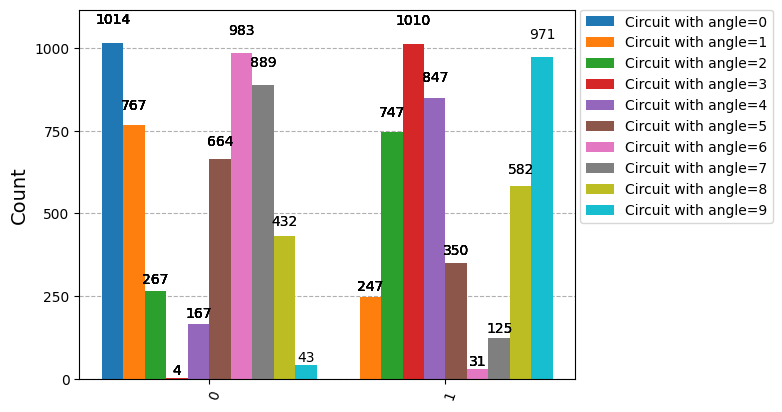

In [23]:
from qiskit.visualization import plot_histogram
from qiskit import transpile

backend = Aer.get_backend("qasm_simulator")
shots = 1014

job = backend.run([transpile(circ, backend) for circ in circuits], shots=shots)
results = job.result()
plot_histogram(results.get_counts(), legend=circuit_names)

## The effect of `transpile`

The `transpile` function was used in the previous lesson. With the help of this function `qiskit` transforms our circuit to the instruction set supported by the backend. What does this circuit look like?

### Small detour: What kind of gates are we really using under the hood?

As we saw in the previous lesson, the $SWAP$ gate actually corresponds to three cleverly used $CNOT$s. Perhaps $CNOT$ can be resolved in the same way? What are the elementary gates we can work with (also known as universal gates)?

A universal gate set can be used to build any quantum circuit.

It can be proven that, for example, by adding the gates $R_x, R_y, R_z$ to the gates $P$ and $CNOT$ we obtain an universal gate-set. (By the way, the set ${CNOT, H, S, T}$ is also universal).

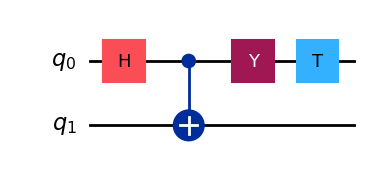

In [24]:
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)
qc.y(0)
qc.t(0)
qc.draw("mpl")

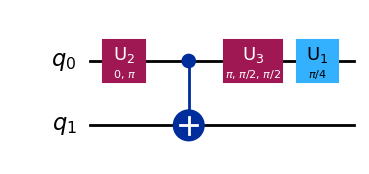

In [25]:
qc.decompose().draw("mpl")

### Let's get back to the original problem

The `transpile` process has 6 steps in `qiskit`:

1. `init` - All gates and instructions are converted to one- or two-bit gates.
2. `layout` - The logic quantum bits of the circuit are mapped to physical quantum bits.
3. `routing` - $SWAP$ gates are inserted based on the physical connections on the backend.
4. `translation` - Translation of the gates to the instruction set used by the backend.
5. `optimization` - Optimization of the circuit.
6. `scheduling` - Here we can specify scheduling related tasks.

A more thorough description of these steps can be found [here](https://docs.quantum.ibm.com/guides/transpile).

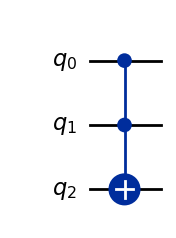

In [26]:
from qiskit_ibm_runtime.fake_provider import FakeAuckland

backend = FakeAuckland()
 
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.draw("mpl")

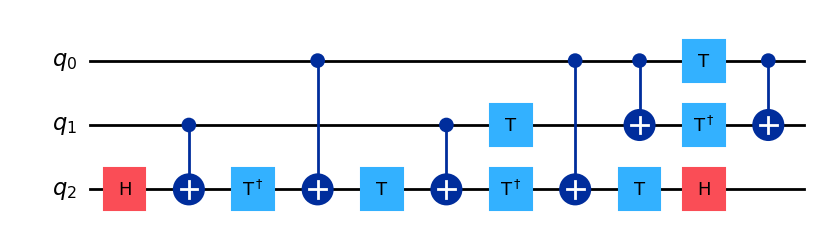

In [27]:
qc.decompose().draw("mpl")

In [28]:
print("native gates:" + str(backend.operation_names))

native gates:['for_loop', 'if_else', 'id', 'x', 'rz', 'reset', 'delay', 'sx', 'cx', 'switch_case', 'measure']


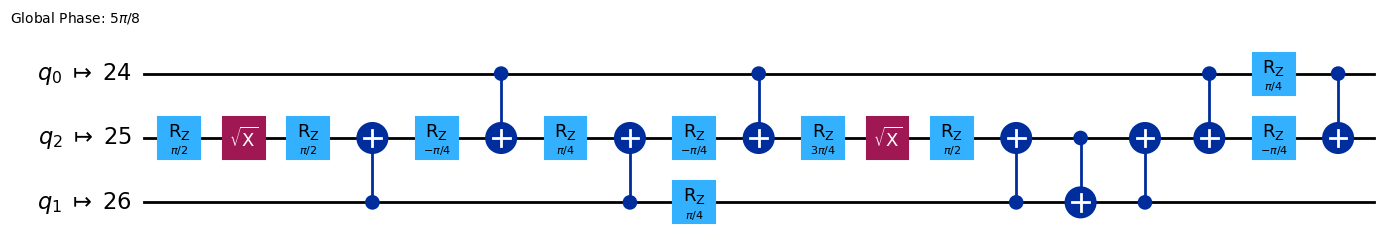

In [29]:
transpile(qc, backend).draw("mpl", idle_wires=False)

Thank you for your attention!